# Sentiment Analysis

---

With the rise of online social media platforms like Twitter, Facebook and Reddit, and the proliferation of customer reviews on sites like Amazon and Yelp, we now have access, more than ever before, to massive text-based data sets! They can be analyzed in order to determine how large portions of the population feel about certain products, events, etc. This sort of analysis is called _sentiment analysis_. In this notebook we will build an end-to-end sentiment classification system from scratch.

In [8]:
import os
import glob
import re
import gensim
import pickle
import random
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

from tqdm import tqdm
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from scipy.sparse import csr_matrix

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
import tensorflow.keras.backend as K

## Step 1: Exploring the data!

The dataset we are going to use is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

In [5]:
def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            print('Fetching:', path)
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in tqdm(files):
                with open(f, encoding="utf8") as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels

In [6]:
# make sure that the imdb file has been already downloaded and is present in "data_dir" 
# before running the code
data, labels = read_imdb_data(data_dir='aclImdb')

Fetching: aclImdb\train\pos\*.txt


100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [04:22<00:00, 47.54it/s]


Fetching: aclImdb\train\neg\*.txt


100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [04:46<00:00, 43.69it/s]


Fetching: aclImdb\test\pos\*.txt


100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [04:16<00:00, 48.69it/s]


Fetching: aclImdb\test\neg\*.txt


100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [06:24<00:00, 32.51it/s]

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [7]:
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that the data is loaded in, let's take a quick look at one of the positive reviews:

In [8]:
print(data['train']['pos'][2])

Brilliant over-acting by Lesley Ann Warren. Best dramatic hobo lady I have ever seen, and love scenes in clothes warehouse are second to none. The corn on face is a classic, as good as anything in Blazing Saddles. The take on lawyers is also superb. After being accused of being a turncoat, selling out his boss, and being dishonest the lawyer of Pepto Bolt shrugs indifferently "I'm a lawyer" he says. Three funny words. Jeffrey Tambor, a favorite from the later Larry Sanders show, is fantastic here too as a mad millionaire who wants to crush the ghetto. His character is more malevolent than usual. The hospital scene, and the scene where the homeless invade a demolition site, are all-time classics. Look for the legs scene and the two big diggers fighting (one bleeds). This movie gets better each time I see it (which is quite often).


And one with a negative sentiment:

In [9]:
print(data['train']['neg'][2])

This film lacked something I couldn't put my finger on at first: charisma on the part of the leading actress. This inevitably translated to lack of chemistry when she shared the screen with her leading man. Even the romantic scenes came across as being merely the actors at play. It could very well have been the director who miscalculated what he needed from the actors. I just don't know.<br /><br />But could it have been the screenplay? Just exactly who was the chef in love with? He seemed more enamored of his culinary skills and restaurant, and ultimately of himself and his youthful exploits, than of anybody or anything else. He never convinced me he was in love with the princess.<br /><br />I was disappointed in this movie. But, don't forget it was nominated for an Oscar, so judge for yourself.


We can also make a wordcloud visualization of the reviews.

**a) Wordcloud for postive reviews**

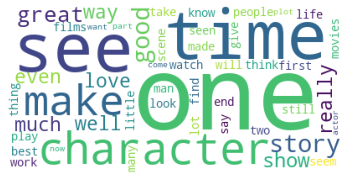

In [10]:
sentiment = 'pos'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

**b) Wordcloud for negative reviews**

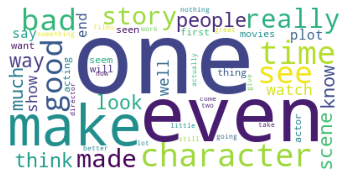

In [11]:
sentiment = 'neg'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

Now that we've seen what the raw data looks like, we combine the positive and negative documents to get one unified training set and one unified test set.

In [19]:
def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test  = data['test']['pos'] + data['test']['neg']
    
    labels_train = ['pos'] * len(data['train']['pos']) + ['neg'] * len(data['train']['neg'])
    labels_test  = ['pos'] * len(data['test']['pos']) + ['neg'] * len(data['test']['neg'])
    
    # Shuffle reviews and corresponding labels within training and test sets
    data_train   = shuffle(data_train, random_state=42)
    data_test    = shuffle(data_test, random_state=42)
    labels_train = shuffle(labels_train, random_state=42)
    labels_test  = shuffle(labels_test, random_state=42)

    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


In [61]:
# with open('cache/data.pickle', 'wb') as f:
#     pickle.dump((data_train, data_test, labels_train, labels_test), f)
    
with open('cache/data.pickle', 'rb') as f:
    data_train, data_test, labels_train, labels_test = pickle.load(f)

## Step 2. Preprocessing

As you might have noticed in the sample reviews, our raw data includes HTML. Therefore there are HTML tags that need to be removed. We also need to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

### Convert each review to words

In [55]:
# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords 
from nltk.corpus import stopwords # import stopwords
from nltk.stem.porter import *

stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2lros\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    # TODO: Remove HTML tags and non-letters,
    #       convert to lowercase, tokenize,
    #       remove stopwords and stem
    
    # 1 Remove HTML tags
    soup = BeautifulSoup(review, "html.parser").stripped_strings
    review = ' '.join(soup)
    
    result = []
    # 2 Remove non-letters, convert to lowercase, tokenize
    for token in gensim.utils.simple_preprocess(review, min_len=0, max_len=999):
        
        # 3 remove stopwords, apply stemming
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(stemmer.stem(token))
         
    # Return final list of words
    return ' '.join(result)

review_to_words("""This is@ just a <em>test</em>.<br/><br />
But if it wasn't a test9, it would make for a <b>Great</b> movie review!""")

'test wasn test great movi review'

With the function `review_to_words()` fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [62]:
cache_dir = "cache"  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

In [63]:
def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
If you ask me the first one was really better one. Look at Sarah M. G., she is real, mean, cruel girl, look at Amy Adams she is just little fool hanging around. She is nothing! People don't adore her! Second, Sebastian was cute and hot in first movie, now he is "baby face". Story is not that good, and i do not understand. Why didn't they make this one first, it is the beginning. Loosy actors, nothing with story. This is not cruel, this is playing. First one has better actors, better story, and its mean. I think that the music is better in cruel intentions 1 and the music is better in cruel intentions 3. It is not the worst movie I saw, but in compaer with first one its one big, big, big nothing.

--- Preprocessed words ---
better look sarah real mean cruel girl look adam littl fool hang peopl ador second sebastian cute movi babi face stori good understand begin loosi actor stori cruel play better actor be

## Step 3: Extracting Bag-of-Words features

Now that each document has been preprocessed, we can transform each into a Bag-of-Words feature representation. Note that we need to create this transformation based on the training data alone, as we are not allowed to peek at the testing data at all!

The dictionary or _vocabulary_ $V$ (set of words shared by documents in the training set) used here will be the one on which we train our supervised learning algorithm. Any future test data must be transformed in the same way for us to be able to apply the learned model for prediction. Hence, it is important to store the transformation / vocabulary as well.

### Compute Bag-of-Words features

We will apply BoW to both training and test datasets, and store the results in `features_train` and `features_test` NumPy arrays, respectively. We choose a reasonable vocabulary size, say $|V| = 5000$, and keep only the top $|V|$ occuring words and discard the rest. This number will also serve as the number of columns in the BoW matrices.

In [58]:
def extract_BoW_features(words_train, words_test, cache_dir, vocabulary_size=5000, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        
        # Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words
        vectorizer = CountVectorizer(max_features=vocabulary_size).fit(words_train)
        features_train = vectorizer.transform(words_train).toarray()

        # Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # Note: We are converting the features using .toarray() for a compact representation
        # so we can make some visualizations with it, although space-wise it is not suggested
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary, vectorizer=vectorizer)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary, vectorizer = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'], cache_data['vectorizer'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary, vectorizer

In [64]:
# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary, vectorizer = extract_BoW_features(words_train, words_test, cache_dir='cache/sentiment_analysis')

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['meantim', 'durat', 'arrang', 'marlon', 'luka', 'water', 'immatur', 'canyon']

--- Preprocessed words ---
incred film document etern struggl indigen disenfranchis peopl gain right voic show unit state dishonesti subterfug blatant disregard human right self determin chavez shown brave charismat leader struggl character despic elit devoid sens proport justic filmmak record coup unlik wit cross hair pull string blur sens realiti heart break watch initi stage revolt know subvers democraci wit tool long success american govern seemingli blinker citizen footag make clear manipul gener footag activ document peopl govern fight futur truli move experi conscienc irish film maker deserv gratitud long live chavez need enshrin notion countri allow choos govern develop way major see phase process need know realiti situat documentari great

--- Bag-of-Words features ---
[0 0 0 ... 0 0 0]

--- Label ---
pos


Let's try to visualize the Bag-of-Words feature vector for one of our training documents.

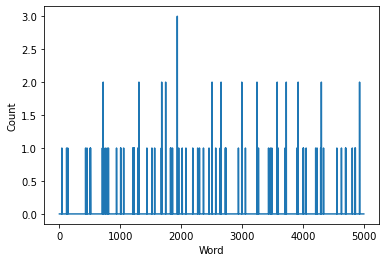

In [78]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Normalize feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [10]:
import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
features_train = pr.normalize(features_train)
features_test = pr.normalize(features_test)

## Step 4: Classification using BoW features

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, we train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [82]:
from sklearn.naive_bayes import GaussianNB

# Train a Guassian Naive Bayes classifier
clf_baseline = GaussianNB().fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf_baseline.__class__.__name__,
        clf_baseline.score(features_train, labels_train),
        clf_baseline.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.82396, test = 0.71832


Tree-based algorithms often work quite well on Bag-of-Words as their highly discontinuous and sparse nature is nicely matched by the structure of trees. As your next task, we will try to improve on the Naive Bayes classifier's performance by using scikit-learn's Gradient-Boosted Decision Tree classifer.

### Gradient-Boosted Decision Tree classifier

This model has a number of parameters. For the sake of simplicity, we will use default parameter values for most of them and try to tune only one of the params: `n_estimators`. We will try to find a proper value for this hyperparameter, use it to classify the data, and observe how much improvement we get over Naive Bayes in terms of accuracy.

In [10]:
def classify_gboost(X_train, X_test, y_train, y_test):   
    
    # Initialize classifier
    params = {'n_estimators': [10, 50, 100, 300, 500]}
    clf = GradientBoostingClassifier(random_state=42)

    # Perform hyperparameter tuning / model selection
    clf_grid= GridSearchCV(clf, params, cv=3, verbose=6, n_jobs=4).fit(X_train, y_train)
    
    clf_best = clf_grid.best_estimator_ 
    print('The best params: ', clf_grid.best_params_)
    
    
    # Print final training & test accuracy
    clf_best.fit(X_train, y_train)
    print("[{}] Accuracy: train = {}, test = {}".format(
        clf_best.__class__.__name__,
        clf_best.score(X_train, y_train),
        clf_best.score(X_test, y_test)))
    
    # Return best classifier model
    return clf_best


clf_gboost = classify_gboost(csr_matrix(features_train), csr_matrix(features_test), labels_train, labels_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  11 out of  15 | elapsed:  4.7min remaining:  1.7min
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  8.1min finished


The best params:  {'n_estimators': 500}
[GradientBoostingClassifier] Accuracy: train = 0.89236, test = 0.84992


In [53]:
# Save your model, so that you can quickly load it in future 
with open('cache/model/model_gboost.pickle', 'wb') as f:
    pickle.dump(clf_gboost, f)

# # load the saved model
# with open('cache/model/model_gboost.pickle', 'rb') as f:
#     clf_gboost = pickle.load(f)

## Step 5: Switching gears - RNNs

We just saw how the task of sentiment analysis can be solved via a traditional machine learning approach: BoW + a nonlinear classifier. We now switch gears and use Recurrent Neural Networks, and in particular LSTMs, to perform sentiment analysis in Keras. Conveniently, Keras has a built-in [IMDb movie reviews dataset](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification) that we can use, with the same vocabulary size.

In [4]:
# import the built-in imdb dataset in TF/Keras
from tensorflow.keras.datasets import imdb

# Set the vocabulary size
vocabulary_size = 5000

# Load in training and test data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))

Loaded dataset with 25000 training samples, 25000 test samples


In [16]:
# Inspect a sample review and its label
print("--- Review ---")
print(X_train[7])
print("--- Label ---")
print(y_train[7])

--- Review ---
[1, 4, 2, 716, 4, 65, 7, 4, 689, 4367, 2, 2343, 4804, 2, 2, 2, 2, 2315, 2, 2, 2, 2, 4, 2, 628, 2, 37, 9, 150, 4, 2, 4069, 11, 2909, 4, 2, 847, 313, 6, 176, 2, 9, 2, 138, 9, 4434, 19, 4, 96, 183, 26, 4, 192, 15, 27, 2, 799, 2, 2, 588, 84, 11, 4, 3231, 152, 339, 2, 42, 4869, 2, 2, 345, 4804, 2, 142, 43, 218, 208, 54, 29, 853, 659, 46, 4, 882, 183, 80, 115, 30, 4, 172, 174, 10, 10, 1001, 398, 1001, 1055, 526, 34, 3717, 2, 2, 2, 17, 4, 2, 1094, 871, 64, 85, 22, 2030, 1109, 38, 230, 9, 4, 4324, 2, 251, 2, 1034, 195, 301, 14, 16, 31, 7, 4, 2, 8, 783, 2, 33, 4, 2945, 103, 465, 2, 42, 845, 45, 446, 11, 1895, 19, 184, 76, 32, 4, 2, 207, 110, 13, 197, 4, 2, 16, 601, 964, 2152, 595, 13, 258, 4, 1730, 66, 338, 55, 2, 4, 550, 728, 65, 1196, 8, 1839, 61, 1546, 42, 2, 61, 602, 120, 45, 2, 6, 320, 786, 99, 196, 2, 786, 2, 4, 225, 4, 373, 1009, 33, 4, 130, 63, 69, 72, 1104, 46, 1292, 225, 14, 66, 194, 2, 1703, 56, 8, 803, 1004, 6, 2, 155, 11, 4, 2, 3231, 45, 853, 2029, 8, 30, 6, 117, 430

Notice that the label is an integer (0 for negative, 1 for positive), and the review itself is stored as a sequence of integers. These are word IDs that have been preassigned to individual words. To map them back to the original words, we have to use the dictionary returned by `imdb.get_word_index()`.

In [5]:
# Map word IDs back to words
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print("--- Review (with words) ---")
print([id2word.get(i, " ") for i in X_train[7]])
print("--- Label ---")
print(y_train[7])

--- Review (with words) ---
['the', 'of', 'and', 'local', 'of', 'their', 'br', 'of', 'attention', 'widow', 'and', 'captures', 'parties', 'and', 'and', 'and', 'and', 'excitement', 'and', 'and', 'and', 'and', 'of', 'and', 'english', 'and', 'like', 'it', 'years', 'of', 'and', 'unintentional', 'this', 'hitchcock', 'of', 'and', 'learn', 'everyone', 'is', 'quite', 'and', 'it', 'and', 'such', 'it', 'bonus', 'film', 'of', 'too', 'seems', 'he', 'of', 'enough', 'for', 'be', 'and', 'editing', 'and', 'and', 'please', 'great', 'this', 'of', 'shoots', 'thing', '3', 'and', "it's", 'mentioning', 'and', 'and', 'given', 'parties', 'and', 'back', 'out', 'interesting', 'times', 'no', 'all', 'average', 'talking', 'some', 'of', 'nor', 'seems', 'into', 'best', 'at', 'of', 'every', 'cast', 'i', 'i', 'inside', 'keep', 'inside', 'large', 'viewer', 'who', 'obscure', 'and', 'and', 'and', 'movie', 'of', 'and', 'entirely', "you've", 'see', 'because', 'you', 'deals', 'successful', 'her', 'anything', 'it', 'of', 'ded

Unlike our Bag-of-Words approach, where we simply summarized the counts of each word in a document, this representation essentially retains the entire sequence of words (minus punctuation, stopwords, etc.). This is critical for RNNs to function. But it also means that now the features can be of different lengths!

**Variable length reviews**

Let's find the maximum and minimum review length (in terms of number of words) in the training set.


In [6]:
len_array = list(map(len, X_train))
print('Max sequence length: ', max(len_array))
print('Min sequence length: ', min(len_array))

Max sequence length:  2494
Min sequence length:  11


### Pad sequences

In order to feed this data into your RNN, all input documents must have the same length. Let's limit the maximum review length to `max_words` by truncating longer reviews and padding shorter reviews with a null value (0). We can accomplish this easily using the [`pad_sequences()`](https://keras.io/preprocessing/sequence/#pad_sequences) function in Keras. For now, we set `max_words` to 500.

In [7]:
# Set the maximum number of words per document (for both training and testing)
max_words = 500

# Pad sequences in X_train and X_test
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

### Design an RNN model for sentiment analysis

Let's build our RNN model. 

Remember that our input is a sequence of words (technically, integer word IDs) of maximum length = `max_words`, and the output is a binary sentiment label (0 or 1).

In [21]:
# Model architecture
max_words = 500
embedding_size = 32
vocabulary_size = 5000 

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8,  activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,  activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

### Train and evaluate your model

Now that we have our data and model ready, we can start training the model. 

Note: In TF, we first need to _compile_ the model by specifying the **loss** function and **optimizer** we want to use while training, as well as any evaluation **metrics** we'd like to measure. 

In [22]:
# Compile the model, specifying a loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Once compiled, we can kick off the training process. There are two important training parameters that we have to specify - **batch size** and **number of training epochs**, which together with the model architecture will determine the total training time.

Training may take a while, so grab a cup of coffee, or better, go for a hike! 

In [26]:
# Specify training parameters: batch size and number of epochs
batch_size = 64
num_epochs = 5

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_split=0.1,
                    shuffle=True)

Epoch 1/5
352/352 [==============================] - 318s 894ms/step - loss: 0.5940 - accuracy: 0.6562 - val_loss: 0.3731 - val_accuracy: 0.8392
Epoch 2/5
352/352 [==============================] - 317s 900ms/step - loss: 0.2932 - accuracy: 0.8864 - val_loss: 0.3114 - val_accuracy: 0.8664
Epoch 3/5
352/352 [==============================] - 316s 899ms/step - loss: 0.2373 - accuracy: 0.9117 - val_loss: 0.3029 - val_accuracy: 0.8768
Epoch 4/5
352/352 [==============================] - 317s 902ms/step - loss: 0.1856 - accuracy: 0.9341 - val_loss: 0.3363 - val_accuracy: 0.8796
Epoch 5/5
352/352 [==============================] - 330s 937ms/step - loss: 0.1511 - accuracy: 0.9478 - val_loss: 0.3491 - val_accuracy: 0.8552


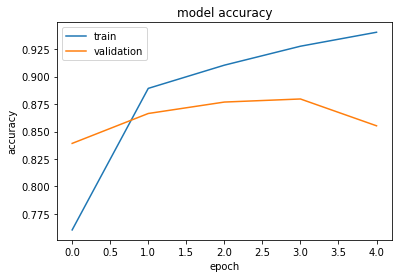

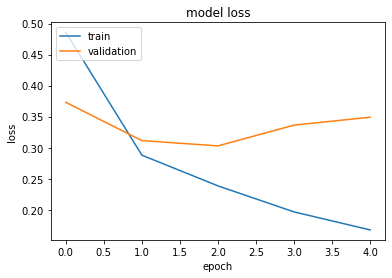

In [38]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [40]:
# Save your model, so that you can quickly load it in future (and perhaps resume training)
model_file = "rnn_model.h5"  # HDF5 file
model.save(os.path.join('cache/model', model_file))

# Later you can load it using keras.models.load_model()
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))

Once you have trained your model, it's time to see evaluate the performance.

In [45]:
# Evaluate on the train and the test set
print("[{}] Accuracy: train = {}, test = {}".format(
        'RNN-based Model',
        model.evaluate(X_train, y_train, verbose=0)[1],
        model.evaluate(X_test, y_test, verbose=0)[1]
    ))

[RNN-based Model] Accuracy: train = 0.9466000199317932, test = 0.865880012512207


## Step 6: Results and Conclusions

**Comparing RNNs and Traditional Methods**

In [49]:
# !pip install prettytable
from prettytable import PrettyTable

x = PrettyTable()

column_names = ["Model", "Train Accuracy", "Val Accuracy"]

x.add_column(column_names[0], ["Naive Bayes", "Gradient Boosting", "LSTM Model"])
x.add_column(column_names[1], [0.82396, 0.89236, 0.94660])  
x.add_column(column_names[2], [0.71832, 0.84992, 0.86588])  

print(x)

+-------------------+----------------+--------------+
|       Model       | Train Accuracy | Val Accuracy |
+-------------------+----------------+--------------+
|    Naive Bayes    |    0.82396     |   0.71832    |
| Gradient Boosting |    0.89236     |   0.84992    |
|     LSTM Model    |     0.9466     |   0.86588    |
+-------------------+----------------+--------------+


As can be seen, a simple LSTM model outperforms our traditional ML algorithms. This can be attributed to the fact that, LSTM can capture temporal behavior, ie the order dependence of the text sequences. Whereas, traditional ML algorithms do not take such things into account.